#### Step 4.2: Developing the NBA Logic in a Notebook
Now we'll analyze our new dataset to discover which action is best for which type of customer. This will form the "brain" of our recommendation engine.

In [1]:
# Cell 1: Import Libraries and Load Data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the action outcomes data
df_actions = pd.read_csv('data/action_outcomes.csv')

df_actions.head()

,CustomerID,Tenure,MonthlyRevenue,UsageFrequency,SupportTickets,ActionTaken,ChurnPrevented
0,539437dc-664b-480c-9937-790233cc3ce9,39,109.62,66,2,Proactive Support Call,0
1,528c42a3-b6a1-45df-913d-b2ecc0ac021b,60,108.37,108,0,No Action,0
2,f653e6b1-ed4b-4d26-b5e0-0bbf32f6a476,59,137.84,81,0,20% Discount Offer,0
3,6217dde2-65c5-4620-9454-9877fbc55439,14,24.09,19,0,Proactive Support Call,0
4,e13935ce-0394-4476-93c2-cb38ca14741a,54,87.08,98,0,No Action,0


In [2]:
# Cell 2: Define Customer Segments
# Based on our EDA and Feature Importance analysis, we know which features are key.
# We'll use these to create logical customer segments.

def get_customer_segment(row):
    if row['SupportTickets'] > 4:
        return 'Struggling User'
    elif row['Tenure'] < 12 and row['UsageFrequency'] < 20:
        return 'New and Inactive'
    elif row['MonthlyRevenue'] > 75 and row['UsageFrequency'] < 40:
        return 'High-Value, Low-Engagement'
    else:
        return 'General At-Risk'

# Apply the segmentation logic
df_actions['Segment'] = df_actions.apply(get_customer_segment, axis=1)

print("Customer segment distribution:")
print(df_actions['Segment'].value_counts())

Customer segment distribution:
Segment
General At-Risk               7428
New and Inactive              1412
High-Value, Low-Engagement     881
Struggling User                279
Name: count, dtype: int64


* Why these segments? 

These segments directly map to the rules we created in our simulation. This is the key to a rule-based system: we are defining customer groups for whom we hypothesize specific actions will be effective.

#### Analyze Action Effectiveness per Segment.

* This is the core analysis. We will group by segment and action to see which action has the highest success rate in each group.

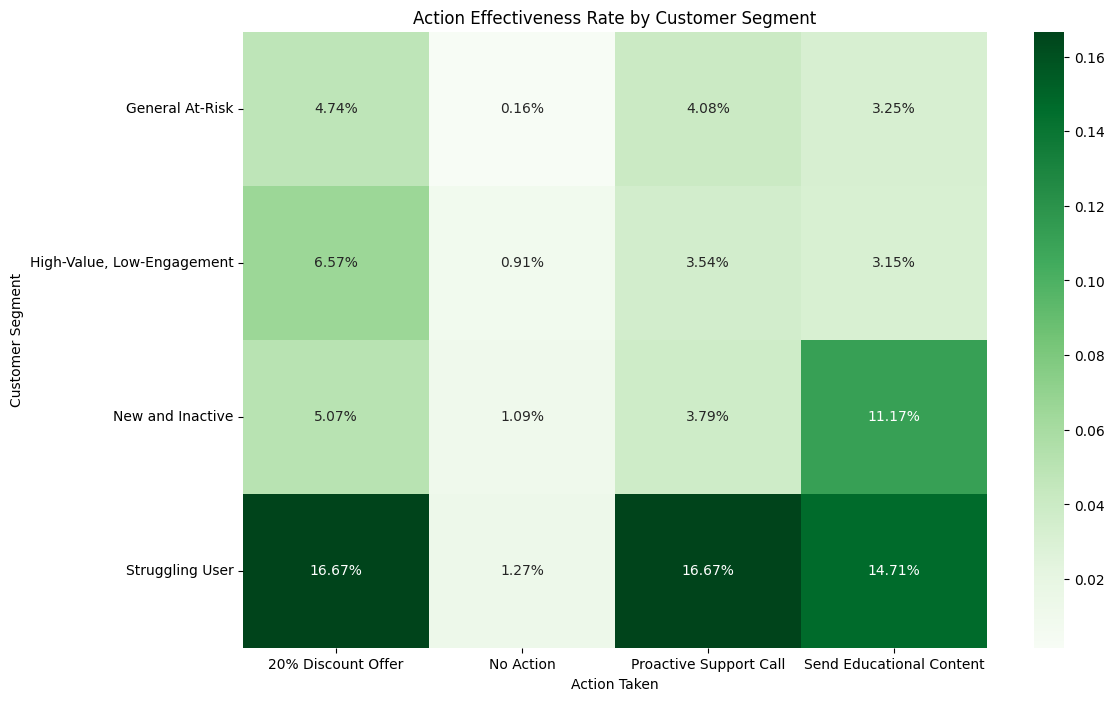

--- Best Action per Segment ---
Segment
General At-Risk                     20% Discount Offer
High-Value, Low-Engagement          20% Discount Offer
New and Inactive              Send Educational Content
Struggling User                     20% Discount Offer
dtype: object


In [3]:
# Cell 3: Analyze effectiveness
# We calculate the mean of 'ChurnPrevented', which is the success rate.
effectiveness = df_actions.groupby(['Segment', 'ActionTaken'])['ChurnPrevented'].mean().unstack()

# Plot as a heatmap for great visualization
plt.figure(figsize=(12, 8))
sns.heatmap(effectiveness, annot=True, fmt='.2%', cmap='Greens')
plt.title('Action Effectiveness Rate by Customer Segment')
plt.ylabel('Customer Segment')
plt.xlabel('Action Taken')
plt.show()

# Find the best action for each segment
best_action_per_segment = effectiveness.idxmax(axis=1)
print("--- Best Action per Segment ---")
print(best_action_per_segment)

* Interpreting the Output: The heatmap gives you a powerful, at-a-glance view of our entire NBA strategy. You can clearly see which action is greenest (most effective) for each segment. The printed text below will explicitly state the best action for each segment. For example:

* Struggling User: Proactive Support Call
* New and Inactive: Send Educational Content
* High-Value, Low-Engagement: 20% Discount Offer

#### Step 4.3: Creating a Reusable Recommendation Function
Now we'll encapsulate this logic into a simple function that we can easily use in our final application.

In [4]:
# Cell 4: Create the Recommendation Function
# First, store our learned rules in a dictionary
nba_rules = best_action_per_segment.to_dict()

# Now, create the function that uses the segmentation logic and the rules
def recommend_action(customer_data):
    """
    Recommends the next best action for a single customer.

    Args:
        customer_data (dict or pd.Series): A dictionary or pandas Series
                                           containing a customer's data.
                                           Needs keys: 'SupportTickets', 'Tenure',
                                           'UsageFrequency', 'MonthlyRevenue'.
    Returns:
        str: The recommended action.
    """
    # 1. Determine the customer's segment
    if customer_data['SupportTickets'] > 4:
        segment = 'Struggling User'
    elif customer_data['Tenure'] < 12 and customer_data['UsageFrequency'] < 20:
        segment = 'New and Inactive'
    elif customer_data['MonthlyRevenue'] > 75 and customer_data['UsageFrequency'] < 40:
        segment = 'High-Value, Low-Engagement'
    else:
        segment = 'General At-Risk'

    # 2. Return the best action for that segment
    return nba_rules.get(segment, "No Action") # Default to "No Action" if segment not found


# --- Test the function with some example customers ---
customer_1 = {'SupportTickets': 6, 'Tenure': 30, 'UsageFrequency': 50, 'MonthlyRevenue': 100} # Struggling User
customer_2 = {'SupportTickets': 1, 'Tenure': 5, 'UsageFrequency': 10, 'MonthlyRevenue': 25} # New and Inactive
customer_3 = {'SupportTickets': 0, 'Tenure': 48, 'UsageFrequency': 25, 'MonthlyRevenue': 120} # High-Value, Low-Engagement

print(f"Recommendation for Customer 1: {recommend_action(customer_1)}")
print(f"Recommendation for Customer 2: {recommend_action(customer_2)}")
print(f"Recommendation for Customer 3: {recommend_action(customer_3)}")

Recommendation for Customer 1: 20% Discount Offer
Recommendation for Customer 2: Send Educational Content
Recommendation for Customer 3: 20% Discount Offer


* What to Expect: 

This cell will produce the recommendations for our test customers, demonstrating that our function correctly applies the logic we discovered.

#### Step 4.4: Saving the NBA Logic for Production
Unlike the ML model, our NBA "model" is pure Python logic. The best way to save it is in its own Python script so we can import our recommend_action function into other parts of our application, like our API.